<a href="https://colab.research.google.com/github/SasikaA073/PR-group-assignment/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1 CNN for image classification

In [39]:
# !wget https://archive.ics.uci.edu/static/public/908/realwaste.zip

In [40]:
# !unzip realwaste.zip

In [41]:
from torchvision import datasets, transforms
import torch
from torch.utils.data import DataLoader

In [42]:
# License: BSD
# Author: Sasank Chilamkurthy

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory

cudnn.benchmark = True
plt.ion()   # interactive mode

In [43]:
import os
num_workers = os.cpu_count()
print(f"Number of CPU cores: {num_workers}")

Number of CPU cores: 2


In [44]:
# use cuda if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [45]:
# Get the mean and variance of the dataset

# Minimal transform to load images as tensors
transform = transforms.Compose([
    transforms.ToTensor()  # Convert to tensor
])

dataset = datasets.ImageFolder(root="realwaste-main/RealWaste", transform=transform)
loader = DataLoader(dataset, batch_size=32, shuffle=False, num_workers=num_workers)

In [46]:
import torch

mean = 0.0
std = 0.0
total_images = 0

for images, _ in loader:
    batch_samples = images.size(0)  # Batch size (number of images in this batch)
    images = images.view(batch_samples, images.size(1), -1)  # Flatten height and width
    mean += images.mean(2).sum(0)  # Sum the mean of each channel
    std += images.std(2).sum(0)    # Sum the std of each channel
    total_images += batch_samples

mean /= total_images
std /= total_images

print(f"Mean: {mean}")
print(f"Standard Deviation: {std}")

Mean: tensor([0.5979, 0.6191, 0.6317])
Standard Deviation: tensor([0.1551, 0.1636, 0.1820])


In [47]:

transform = transforms.Compose([
    transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean, std=std)
])

data_dir = '/content/realwaste-main/RealWaste'

dataset = datasets.ImageFolder(root=data_dir, transform=transform)
train_size = int(0.6 * len(dataset))  # 80% train, 20% validation
val_size = int(0.2 * len(dataset))
test_size = len(dataset) - train_size - val_size

# new transformation

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])
image_datasets = {'train': train_dataset, 'val': val_dataset, 'test': test_dataset}

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

dataloaders = {'train': train_loader, 'val': val_loader, 'test': test_loader}

print(f"Number of training examples: {len(train_dataset)}")
print(f"Number of validation examples: {len(val_dataset)}")
print(f"Number of testing examples: {len(test_dataset)}")

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}
class_names = image_datasets['train'].dataset.classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Number of training examples: 2851
Number of validation examples: 950
Number of testing examples: 951


In [48]:
print(f"{mean=}")
print(f"{std=}")

mean=tensor([0.5979, 0.6191, 0.6317])
std=tensor([0.1551, 0.1636, 0.1820])


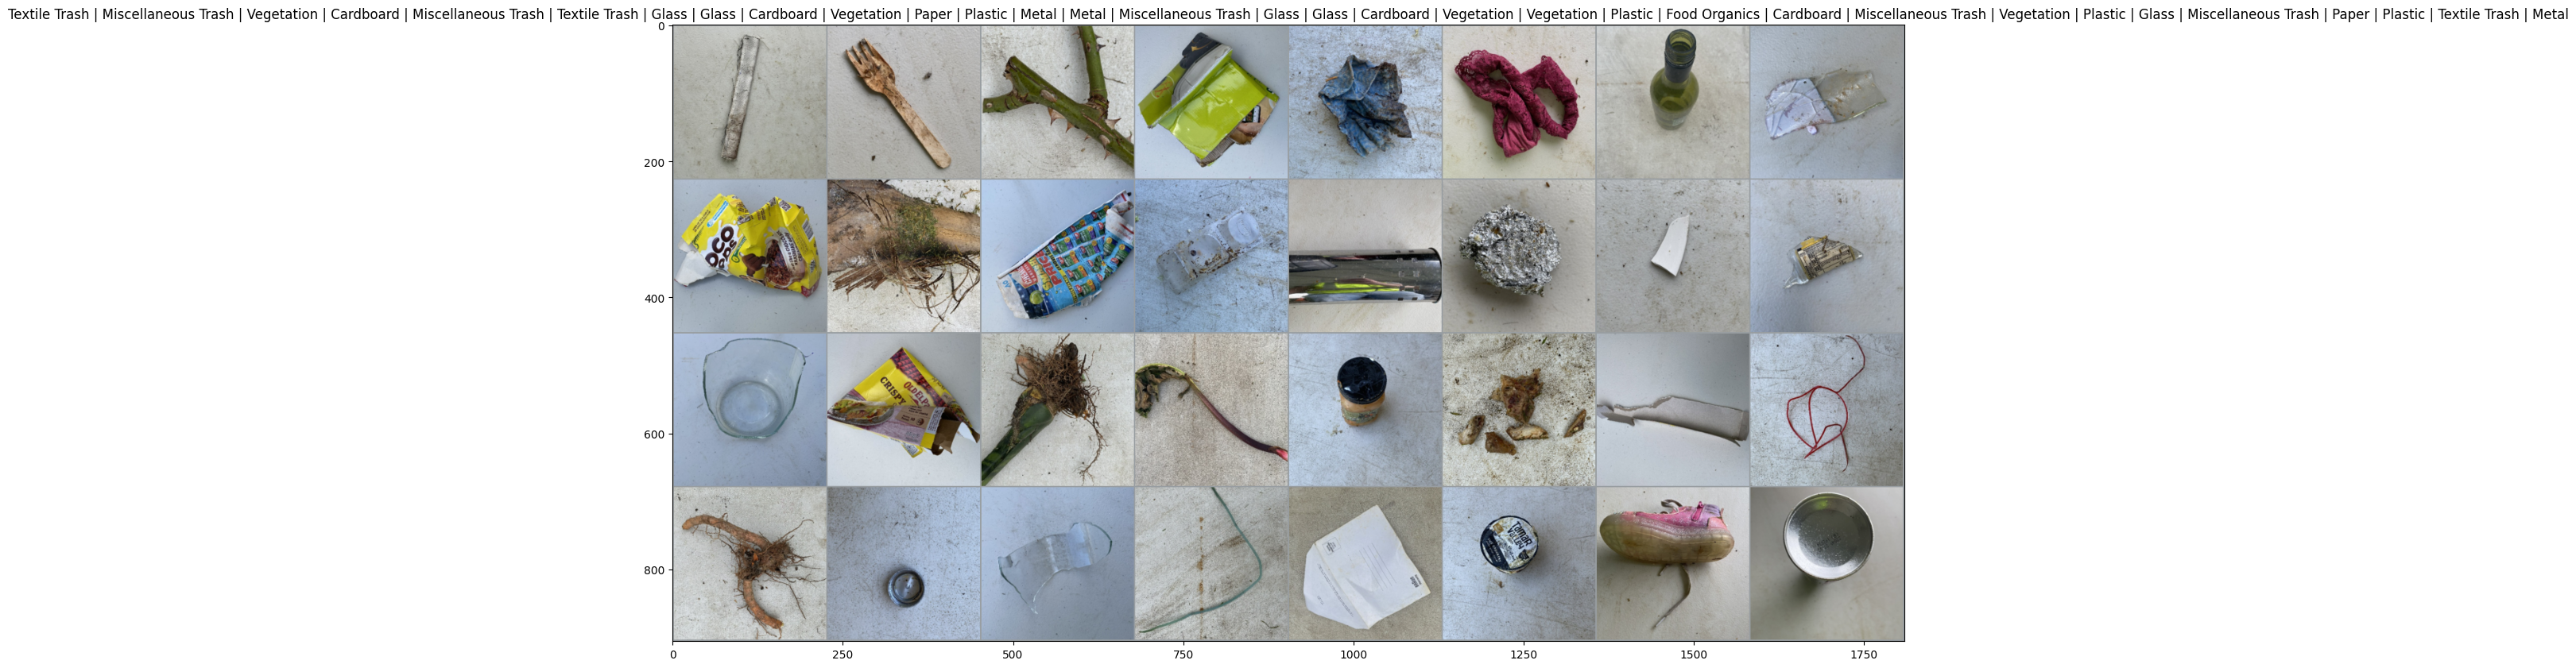

In [49]:
import numpy as np
import matplotlib.pyplot as plt
import torchvision

def imshow(inp, title=None, figsize=(15, 15)):
    """Display image for Tensor with a larger figure size."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.5979, 0.6191, 0.6317])
    std = np.array([0.1551, 0.1636, 0.1820])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)

    # Create a larger figure
    plt.figure(figsize=figsize)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # Pause a bit so that plots are updated

# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from the batch
out = torchvision.utils.make_grid(inputs)

# Adjust the class names mapping as needed
class_names = image_datasets['train'].dataset.classes  # Use classes from the ImageFolder

# Display the image with a larger plot
imshow(out, title=" | ".join([class_names[x] for x in classes]), figsize=(20, 20))


In [50]:
next(iter(train_loader))[0].shape

torch.Size([32, 3, 224, 224])

In [51]:
dataset.classes

['Cardboard',
 'Food Organics',
 'Glass',
 'Metal',
 'Miscellaneous Trash',
 'Paper',
 'Plastic',
 'Textile Trash',
 'Vegetation']

In [52]:
dataset.class_to_idx

{'Cardboard': 0,
 'Food Organics': 1,
 'Glass': 2,
 'Metal': 3,
 'Miscellaneous Trash': 4,
 'Paper': 5,
 'Plastic': 6,
 'Textile Trash': 7,
 'Vegetation': 8}

In [57]:
vgg16_model = torchvision.models.vgg16(pretrained=False)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [58]:
vgg16_model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [65]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt

d = dropout_rate = 0.5
K = len(dataset.classes)

class TrashClassifier(nn.Module):
    def __init__(self):
        super().__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1, stride=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1, stride=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1, stride=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1, stride=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1),

            # Flatten the output
            nn.Flatten()
        )

        # Add a method to calculate the flattened features
        self.calculate_flattened_features = self._get_flattened_features()

        self.classifier = nn.Sequential(
            nn.Linear(in_features=self.calculate_flattened_features, out_features=512),
            nn.ReLU(),
            nn.Dropout(p=dropout_rate, inplace=False),
            nn.Linear(in_features=512, out_features=K),
            nn.Softmax(dim=1)
        )

    def _get_flattened_features(self):
        # Use a dummy input to calculate the number of flattened features
        test_input = torch.randn(1, 3, 224, 224)  # Assuming input image size is 224x224
        with torch.no_grad():
            x = self.encoder(test_input)
            return x.shape[1]

    def forward(self, x):
        x = self.encoder(x)
        x = self.classifier(x)
        return x

    def test_archtecture(self, x):
        print("")
        for layer in self.encoder:
            x = layer(x)
            print(f"Layer: {layer.__class__.__name__}, Output shape: {x.shape}")

        print("Classifier :")
        for layer in self.classifier:
            x = layer(x)
            print(f"Layer: {layer.__class__.__name__}, Output shape: {x.shape}")

In [60]:
next(iter(train_loader))[0].shape

torch.Size([32, 3, 224, 224])

In [55]:
torch.device

torch.device

In [61]:
random_test_tensor = torch.randn(3, 224, 224).unsqueeze(0)

In [63]:
random_test_tensor.shape

torch.Size([1, 3, 224, 224])

In [66]:
trash_classifier = TrashClassifier()
trash_classifier.test_archtecture(random_test_tensor)


Layer: Conv2d, Output shape: torch.Size([1, 64, 224, 224])
Layer: ReLU, Output shape: torch.Size([1, 64, 224, 224])
Layer: MaxPool2d, Output shape: torch.Size([1, 64, 112, 112])
Layer: Conv2d, Output shape: torch.Size([1, 128, 112, 112])
Layer: ReLU, Output shape: torch.Size([1, 128, 112, 112])
Layer: MaxPool2d, Output shape: torch.Size([1, 128, 56, 56])
Layer: Conv2d, Output shape: torch.Size([1, 256, 56, 56])
Layer: ReLU, Output shape: torch.Size([1, 256, 56, 56])
Layer: MaxPool2d, Output shape: torch.Size([1, 256, 28, 28])
Layer: Conv2d, Output shape: torch.Size([1, 512, 28, 28])
Layer: ReLU, Output shape: torch.Size([1, 512, 28, 28])
Layer: MaxPool2d, Output shape: torch.Size([1, 512, 28, 28])
Layer: Flatten, Output shape: torch.Size([1, 401408])
Classifier :
Layer: Linear, Output shape: torch.Size([1, 512])
Layer: ReLU, Output shape: torch.Size([1, 512])
Layer: Dropout, Output shape: torch.Size([1, 512])
Layer: Linear, Output shape: torch.Size([1, 9])
Layer: Softmax, Output shape

In [ ]:
import time

def train_model(model, criterion, optimizer, scheduler, num_epochs=20):
    since = time.time()

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        # Lists to store metrics for plotting
        train_losses, val_losses = [], []
        train_accuracies, val_accuracies = [], []

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                if phase == 'train':
                    train_losses.append(epoch_loss)
                    train_accuracies.append(epoch_acc.item())
                    scheduler.step()
                else:
                    val_losses.append(epoch_loss)
                    val_accuracies.append(epoch_acc.item())

                # deep copy the model
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path, weights_only=True))

    losses = {'train': train_losses, 'val': val_losses}
    accuracies = {'train': train_accuracies, 'val': val_accuracies}

    return model, losses, accuracies

In [ ]:
len(loader)

In [ ]:
for batch, _ in train_loader:
    print(batch.shape)
    sample_image = batch[0]
    print(sample_image.shape)
    break

In [ ]:
sample_image.shape

In [ ]:
trash_classifier_from_scratch = TrashClassifier()

finetuned_model, losses, accuracies = train_model(
    model=trash_classifier_from_scratch,
    criterion=nn.CrossEntropyLoss(),
    optimizer=optim.Adam(trash_classifier_from_scratch.parameters(), lr=0.001),
)

In [ ]:






# # Training script
# def train_model(model, train_loader, val_loader, num_epochs=20, learning_rate=0.001):
#     device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#     model.to(device)

#     # Define loss function and optimizer
#     criterion = nn.CrossEntropyLoss()
#     optimizer = optim.Adam(model.parameters(), lr=learning_rate)

#     train_losses = []
#     val_losses = []

#     for epoch in range(num_epochs):
#         model.train()
#         running_loss = 0.0

#         for images, labels in train_loader:
#             images, labels = images.to(device), labels.to(device)

#             # Forward pass
#             outputs = model(images)
#             loss = criterion(outputs, labels)

#             # Backward pass and optimization
#             optimizer.zero_grad()
#             loss.backward()
#             optimizer.step()

#             running_loss += loss.item()

#         train_loss = running_loss / len(train_loader)
#         train_losses.append(train_loss)

#         # Validation phase
#         model.eval()
#         val_loss = 0.0
#         with torch.no_grad():
#             for images, labels in val_loader:
#                 images, labels = images.to(device), labels.to(device)
#                 outputs = model(images)
#                 loss = criterion(outputs, labels)
#                 val_loss += loss.item()

#         val_loss /= len(val_loader)
#         val_losses.append(val_loss)

#         print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")

#     # Plotting losses
#     plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
#     plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
#     plt.xlabel('Epochs')
#     plt.ylabel('Loss')
#     plt.legend()
#     plt.title('Training and Validation Loss')
#     plt.show()

In [ ]:
# import vgg16 model
from torchvision import models

vgg16 = models.vgg16(pretrained=False)
vgg16

In [ ]:
# class TrashDataset(torch.utils.data.Dataset):
#     def __init__(self, data, targets, transform=None):
#         self.data = data
#         self.targets = targets
#         self.transform = transform

#     def __getitem__(self, index):
#         x = self.data[index]
#         y = self.targets[index]

#         if self.transform:
#             x = self.transform(x)

#         return x, y

#     def __len__(self):
#         return len(self.data)

In [ ]:

# # Example usage:
# dataset = TrashDataset("realwaste", transform=transform)
# train_size = int(0.6 * len(dataset))
# val_size = int(0.2 * len(dataset))
# test_size = len(dataset) - train_size - val_size
# train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
# val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
# test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# model = TrashClassifier(x1=32, m1=3, x2=64, m2=3, x3=128, d=0.5, K=10)
# train_model(model, train_loader, val_loader)

# # Assuming train_dataset and val_dataset are pre-defined PyTorch datasets
# # train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
# # val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
# # model = TrashClassifier(x1=32, m1=3, x2=64, m2=3, x3=128, d=0.5, K=10)
# # train_model(model, train_loader, val_loader)

In [ ]:
import os
os.listdir("realwaste-main/RealWaste")

In [ ]:
import os
os.getcwd()

In [ ]:
break

# 2 Pretrained Model

In [ ]:
# pretrained_transforms = models.resnet50.

In [ ]:
from torchvision import models

pretrained_trash_classifier = models.resnet50(weights = "IMAGENET1K_V2")
pretrained_trash_classifier

In [ ]:
num_in_features = pretrained_trash_classifier.fc.in_features
num_in_features

In [ ]:
from torch.optim import lr_scheduler

num_out_features = len(dataset.classes)
pretrained_trash_classifier.fc = nn.Linear(in_features = num_in_features,
                                           out_features=num_out_features)

pretrained_trash_classifier = pretrained_trash_classifier.to(device)

criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(pretrained_trash_classifier.parameters(), lr=0.001)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [ ]:
before_training_tc_conv_1_layer_values = pretrained_trash_classifier.conv1.weight.data.clone()
before_training_tc_conv_1_layer_values

In [ ]:
before_training_tc_fc_1_layer_values = pretrained_trash_classifier.fc.weight.data.clone()
before_training_tc_fc_1_layer_values

In [ ]:
before_training_tc_fc_1_layer_values.shape

### Finetuning the Pretrained model

In [ ]:
# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer=optimizer, step_size=7, gamma=0.1)

In [ ]:
finetuned_model, losses, accuracies = train_model(model=pretrained_trash_classifier, criterion=criterion, optimizer=optimizer,scheduler=exp_lr_scheduler, num_epochs=20)

In [ ]:
import matplotlib.pyplot as plt

# Data from the epochs
train_loss = losses['train']
val_loss = losses['val']
train_acc = accuracies['train']
val_acc = accuracies['val']

epochs = list(range(20))

# Plot Loss
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, label='Train Loss', marker='o')
plt.plot(epochs, val_loss, label='Validation Loss', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train and Validation Loss')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc, label='Train Accuracy', marker='o')
plt.plot(epochs, val_acc, label='Validation Accuracy', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Train and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()
